In [24]:
allow_overwrite: bool = True

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.transforms import Affine2D
from matplotlib.transforms import ScaledTranslation
import seaborn as sns
import scienceplots
import numpy as np
import re
import os
from permetrics import RegressionMetric
import h5py
from collections import defaultdict
from tqdm.auto import tqdm
from itertools import product
from scipy.stats import skew, pearsonr
from pyhere import here

In [9]:
DATA_PATH = here("data", "results", "predictions")

In [10]:
BRIGHT_PALETTE = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB', '#BBBBBB']
MODELS_PROP=[
    ('RiboMIMO', 'RiboMIMO', 'RM', False, BRIGHT_PALETTE[0]),
    ('BiLSTM-CSH', 'BiLSTM [SH]', 'BLSH', False, BRIGHT_PALETTE[1]),
    ('BiLSTM-DH', 'BiLSTM [DH]', 'BLDH', True, BRIGHT_PALETTE[2]),
    ('XLNet-CSH', 'Riboclette [SH]', 'RSH', False, BRIGHT_PALETTE[3]),
    ('XLNet-DH', 'Riboclette [DH]', 'RDH', True,BRIGHT_PALETTE[4]),
    ('XLNet-PLabelDH_exp1', 'Riboclette [DH] + PL [T]', 'RDHPLT', True,BRIGHT_PALETTE[5]),
    ('XLNet-PLabelDH_exp2', 'Riboclette [DH] + PL [G]', 'RDHPLG', True,BRIGHT_PALETTE[6]),
]
MODELS_PROP = pd.DataFrame(MODELS_PROP).rename(columns={0:'fname', 1:'model', 2:'abbr',3:'is_dh',4:'color'})
MODELS_PROP

,fname,model,abbr,is_dh,color
0,RiboMIMO,RiboMIMO,RM,False,#4477AA
1,BiLSTM-CSH,BiLSTM [SH],BLSH,False,#EE6677
2,BiLSTM-DH,BiLSTM [DH],BLDH,True,#228833
3,XLNet-CSH,Riboclette [SH],RSH,False,#CCBB44
4,XLNet-DH,Riboclette [DH],RDH,True,#66CCEE
5,XLNet-PLabelDH_exp1,Riboclette [DH] + PL [T],RDHPLT,True,#AA3377
6,XLNet-PLabelDH_exp2,Riboclette [DH] + PL [G],RDHPLG,True,#BBBBBB


In [128]:
CONDITIONS_FIXNAME = {
        'CTRL': 'CTRL',
        'VAL': 'VAL (V)',
        'ILE': 'ILE (I)',
        'LEU': 'LEU (L)',
        'LEU_ILE': '(L, I)', 
        'LEU_ILE_VAL': '(L, I, V)'}
CONDITIONS_FIXNAME_INV = {v: k for k, v in CONDITIONS_FIXNAME.items()}

In [11]:
from abc import ABC, abstractmethod

class Metric(ABC):
    @abstractmethod
    def compute(self, y_true, y_pred):
        pass

    def masked_compute(self, y_true, y_pred):
        nan_mask = ~np.isnan(y_true)
        y_true = y_true[nan_mask]
        y_pred = y_pred[nan_mask]
        return self.compute(y_true, y_pred)

In [12]:
class PCC(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.pearson_correlation_coefficient()
    
class MAE(Metric):
    def compute(self, y_true, y_pred):
        evaluator = RegressionMetric(y_true, y_pred)
        return evaluator.mean_absolute_error()

class MAAPE(Metric):
    def compute(self, y_true, y_pred, eps=1e-10):
        evaluator = RegressionMetric(y_true+eps, y_pred)
        return evaluator.mean_arctangent_absolute_percentage_error()*100

In [13]:
metric_to_func = dict(
    PCC=PCC(),
    MAE=MAE(),
    MAAPE=MAAPE()
)

In [14]:
def compute_performance_metrics(fpath, abbr, is_dh, seed):
    sample_perf = defaultdict(list)
    with h5py.File(fpath, 'r') as f:
        if is_dh:
            ctrl_pred = f['y_pred_ctrl'][:]
            depr_pred = f['y_pred_depr_diff'][:]
            ctrl_true = f['y_true_ctrl'][:]
            depr_true = f['y_true_dd'][:]

        cond_pred = f['y_pred_full'][:]
        cond_true = f['y_true_full'][:]

        conditions = f['condition'][:].astype('U')
        conditions = np.char.replace(conditions, '-', '_')

        transcripts = [re.sub(r'[^A-Za-z0-9.]', '', t) for t in f['transcript'][:].astype('U')]

        for sample_idx in range(cond_true.shape[0]):
            condition = conditions[sample_idx]
            for m, f in metric_to_func.items():
                
                if is_dh and condition != 'CTRL':
                    depr_val = f.masked_compute(y_true=depr_true[sample_idx], y_pred=depr_pred[sample_idx])
                else:
                    depr_val = None
                sample_perf[f"depr_{m}"].append(depr_val)

                if is_dh:
                    ctrl_val = f.masked_compute(y_true=ctrl_true[sample_idx], y_pred=ctrl_pred[sample_idx])
                else:
                    ctrl_val = None
                sample_perf[f"ctrl_{m}"].append(ctrl_val)

                sample_perf[f"cond_{m}"].append(
                   f.masked_compute(y_true=cond_true[sample_idx], y_pred=cond_pred[sample_idx]))

            sample_perf["condition"].append(condition)
            sample_perf["n_codons"].append(len(cond_true[sample_idx]))

            sample_perf["transcript"].append(transcripts[sample_idx])

            # sample_perf["depr_skew"].append(skew(depr_true[sample_idx], nan_policy="omit"))
            # sample_perf["depr_kurtosis"].append(kurtosis(depr_true[sample_idx], nan_policy="omit"))
            # sample_perf["depr_var"].append(np.nanvar(depr_true[sample_idx]))
            # sample_perf["depr_std"].append(np.nanstd(depr_true[sample_idx]))
            # sample_perf["depr_mean"].append(np.nanmean(np.abs(depr_true[sample_idx])))
            # sample_perf["depr_max"].append(np.nanmax(depr_true[sample_idx]))

            # sample_perf["ctrl_skew"].append(skew(ctrl_true[sample_idx], nan_policy="omit"))
            # sample_perf["ctrl_kurtosis"].append(kurtosis(ctrl_true[sample_idx], nan_policy="omit"))
            # sample_perf["ctrl_var"].append(np.nanvar(ctrl_true[sample_idx]))
            # sample_perf["ctrl_std"].append(np.nanstd(ctrl_true[sample_idx]))
            # sample_perf["ctrl_mean"].append(np.nanmean(ctrl_true[sample_idx]))

            # sample_perf["cond_mean"].append(np.nanmean(cond_true[sample_idx]))

    return pd.DataFrame(sample_perf).assign(abbr=abbr, seed=seed)

In [15]:
from itertools import product 

data=pd.concat([
    compute_performance_metrics(os.path.join(DATA_PATH, f'{fname}_S{seed}.h5'), abbr, is_dh, seed)
    for (_, (fname, _, abbr, is_dh, _)), seed in tqdm(list(product(MODELS_PROP.iterrows(), [1,2,3,4,42])))
])

  0%|          | 0/35 [00:00<?, ?it/s]

In [16]:
def compute_stats(fpath):

    sample_perf = defaultdict(list)
    with h5py.File(fpath, 'r') as f:
        ctrl_pred = f['y_pred_ctrl'][:]
        depr_pred = f['y_pred_depr_diff'][:]
        ctrl_true = f['y_true_ctrl'][:]
        depr_true = f['y_true_dd'][:]

        conditions = f['condition'][:].astype('U')
        conditions = np.char.replace(conditions, '-', '_')

        transcripts = [re.sub(r'[^A-Za-z0-9.]', '', t) for t in f['transcript'][:].astype('U')]

    for sample_idx in range(ctrl_true.shape[0]):
        condition = conditions[sample_idx]
        sample_perf["condition"].append(condition)
        sample_perf["n_codons"].append(len(ctrl_true[sample_idx]))

        sample_perf["transcript"].append(transcripts[sample_idx])
                
        sample_perf["ctrl_mean"].append(np.nanmean(ctrl_true[sample_idx]))
        sample_perf["ctrl_var"].append(np.nanvar(ctrl_true[sample_idx]))
        sample_perf["ctrl_skew"].append(skew(ctrl_true[sample_idx], nan_policy='omit'))

        sample_perf["depr_mean"].append(np.nanmean(depr_true[sample_idx]))
        sample_perf["depr_var"].append(np.nanvar(depr_true[sample_idx]))
        sample_perf["depr_skew"].append(skew(depr_true[sample_idx], nan_policy='omit'))
    
    return sample_perf
stast_best_model = compute_stats(os.path.join(DATA_PATH, f'XLNet-PLabelDH_exp1_S1.h5'))

In [17]:
pd.DataFrame(stast_best_model).query('condition == VAL"')

TokenError: ('unterminated string literal (detected at line 1)', (1, 17))

<Axes: xlabel='depr_PCC', ylabel='depr_skew'>

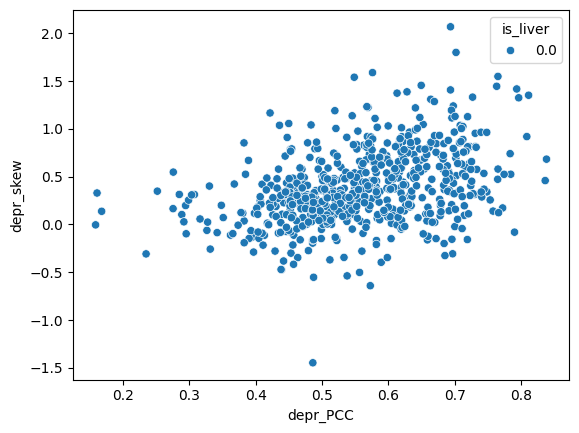

In [69]:
plot_data = (pd.DataFrame(stast_best_model).query('condition == "VAL"').merge(data.query('abbr == "RDHPLT" and condition == "VAL" and seed == 1'), on='transcript')
             .assign(is_liver=lambda df: df.transcript.isin(np.load('/nfs_home/nallapar/final/riboclette/riboclette/models/data/extras/liver_transcripts.npz')['arr_0']))
             .get(['depr_PCC', 'depr_skew', 'is_liver'])
             .astype(float))

sns.scatterplot(data=plot_data.query('depr_PCC > 0'), x='depr_PCC', y='depr_skew', hue='is_liver')

<Axes: xlabel='ctrl_PCC', ylabel='ctrl_skew'>

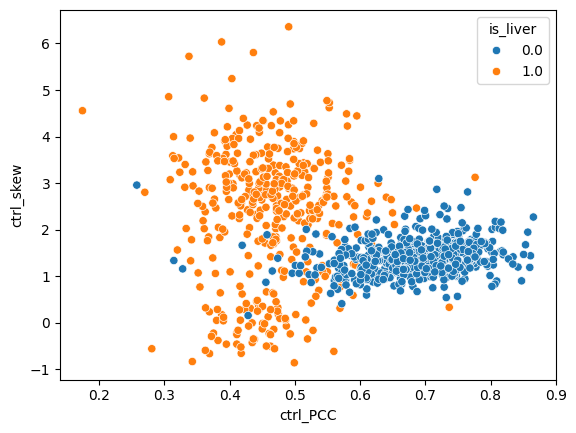

In [70]:
plot_data = (pd.DataFrame(stast_best_model).query('condition == "CTRL"').merge(data.query('abbr == "RDHPLT" and condition == "CTRL" and seed == 1'), on='transcript')
             .assign(is_liver=lambda df: df.transcript.isin(np.load('/nfs_home/nallapar/final/riboclette/riboclette/models/data/extras/liver_transcripts.npz')['arr_0']))
             .get(['ctrl_PCC', 'ctrl_skew', 'is_liver'])
             .astype(float))

sns.scatterplot(data=plot_data.query('ctrl_PCC > 0'), x='ctrl_PCC', y='ctrl_skew', hue='is_liver')


In [56]:
plot_data

,ctrl_PCC,ctrl_mean
0,0.487867,0.321133
1,0.497611,0.356464
2,0.469873,0.293619
3,0.736542,0.376450
4,0.404909,0.343967
...,...,...
1052,0.723618,0.431026
1053,0.847418,0.400457
1054,0.653776,0.461530
1055,0.532190,0.375859


In [18]:
data = data.replace({
    'condition': {
        'VAL': 'VAL (V)',
        'ILE': 'ILE (I)',
        'LEU': 'LEU (L)',
        'LEU_ILE': '(L, I)', 
        'LEU_ILE_VAL': '(L, I, V)'}})

In [ ]:
# data = data.query('condition != "CTRL"')

In [19]:
TEXTWIDTH_CM = 18
CM_TO_INCH = 1/2.54  # centimeters in inches
CONDITION_ORDER = ['CTRL', 'ILE (I)', 'LEU (L)', 'VAL (V)', '(L, I)', '(L, I, V)']

In [ ]:
# df_condition_pcc = (pd.read_csv('Performance.csv')
#  .melt(id_vars='Condition', var_name='Model', value_name='PCC')
#  .assign(
#      Seed=lambda df: [[el for el in re.findall(r"S\d+", x)] for x in df.PCC],
#      PCC=lambda df: [[float(el) for el in re.findall(r"\d+\.\d+", x)] for x in df.PCC])
#  .explode(['Seed','PCC'])
#  .replace({
#      'Model': {
#       ' XL-Net 1 (64+6) DH Seed Best': 'XLNet DH',
#       'XL-Net 1 DH (PLabel)': 'XLNet DH+PL',
#       'XL-Net 1 SH (L: MAE+PCC)': 'XLNet SH', 
#       'LSTM DH (L: MAE+PCC)': 'LSTM DH',
#       'LSTM SH (L: MAE+PCC)': 'LSTM SH'}, 
#     'Condition': {
#         'CTRL + Liver': 'CTRL', 
#         'LEU_ILE': '(LEU, ILE)', 
#         'LEU_ILE_VAL': '(LEU, ILE, VAL)'
#     }}
# ))
# df_condition_pcc

FileNotFoundError: [Errno 2] No such file or directory: 'Performance.csv'

In [20]:
palette_df = pd.DataFrame.from_dict(dict(
    Model = ['Riboclette DH+IM', 'Riboclette DH', 'LSTM DH', 'RiboMIMO'],
    Palette = np.array(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])[[0,1,4,5]]
))
palette_dict = dict(zip(palette_df['Model'], palette_df['Palette']))

In [ ]:
# df_condition_pcc = (
#     pd.DataFrame.from_dict({
#         'Order': [1, 3, 2, 5, 6, 4],
#         'Condition': ['CTRL', 'LEU', 'ILE', '(LEU, ILE)', '(LEU, ILE, VAL)', 'VAL'],
#         'Riboclette DH': [0.5979, 0.6893, 0.6382, 0.6798, 0.689, 0.6997],
#         'LSTM DH': [0.525, 0.6092, 0.5163, 0.6005, 0.656, 0.6602],
#         'RiboMIMO': [0.3898, 0.5958, 0.5421, 0.5899, 0.5888, 0.6129]
#     })
#     .melt(id_vars=['Condition', 'Order'], var_name='Model', value_name='PCC')
#     .assign(Model=lambda df: pd.Categorical(df.Model, ['RiboMIMO', 'LSTM DH', 'Riboclette DH']))
#     .sort_values('Model'))
# df_condition_pcc

,Condition,Order,Model,PCC
17,VAL,4,RiboMIMO,0.6129
15,"(LEU, ILE)",5,RiboMIMO,0.5899
14,ILE,2,RiboMIMO,0.5421
13,LEU,3,RiboMIMO,0.5958
12,CTRL,1,RiboMIMO,0.3898
16,"(LEU, ILE, VAL)",6,RiboMIMO,0.5888
11,VAL,4,LSTM DH,0.6602
10,"(LEU, ILE, VAL)",6,LSTM DH,0.6560
9,"(LEU, ILE)",5,LSTM DH,0.6005
8,ILE,2,LSTM DH,0.5163


In [ ]:
# PCCs =[0.6816, 0.6759, 0.68, 0.6788, 0.6789] + [0.659, 0.6438, 0.6557, 0.6209, 0.6531] + [0.5831, 0.58, 0.5808, 0.5806, 0.5811] + [0.5532]
# MAEs = [.218, .2213, .2176, .2168, .2198] + [0.2231, 0.231, 0.2242, 0.2328, 0.2232] + [np.nan] * 6
# Models = ['Riboclette DH+IM'] * 5 + ['Riboclette DH'] * 5 + ['LSTM DH'] * 5 + ['RiboMIMO']

# df_overall_pcc = (
#     pd.DataFrame(np.array([PCCs, MAEs]).T, columns=['PCC', 'MAE']).assign(Model=Models)
#     .assign(Model=lambda df: pd.Categorical(df.Model, ['RiboMIMO', 'LSTM DH', 'Riboclette DH', 'Riboclette DH+IM']))
#     .sort_values('Model'))
# df_overall_pcc

,PCC,MAE,Model
15,0.5532,NaN,RiboMIMO
10,0.5831,NaN,LSTM DH
11,0.5800,NaN,LSTM DH
12,0.5808,NaN,LSTM DH
13,0.5806,NaN,LSTM DH
14,0.5811,NaN,LSTM DH
5,0.6590,0.2231,Riboclette DH
6,0.6438,0.2310,Riboclette DH
7,0.6557,0.2242,Riboclette DH
8,0.6209,0.2328,Riboclette DH


In [ ]:
# df_imputation = (
#     pd.DataFrame.from_dict({
#         'Trainset Size': [17897] * 5 + [17897] * 5 + [92700] * 5 + [128808] * 5,
#         'PCC': [0.659, 0.6438, 0.6557, 0.6209, 0.6531] + [0.6644, 0.6301, 0.6605, 0.6303, 0.6338] + [0.6793, 0.6768, 0.6795, 0.6795, 0.6817] + [0.6757, 0.6754, 0.6802, 0.6732, 0.6797],
#         'MAE': [0.2231, 0.231, 0.2242, 0.2328, 0.2232] + [0.2198, 0.2273, 0.2226, 0.2198, 0.2198] + [0.2236, 0.2243, 0.2209, 0.2253, 0.2217] + [0.2198, 0.2271, 0.2197, 0.2269, 0.2264],
#         'Imputed': ['None'] * 5 + ['T'] * 5 + ['(T, D)'] * 5 + ['(T, D, M)'] * 5,
#         'Color': [PALETTE_TO_MODEL["Riboclette DH"]] * 5 + [BRIGHT_PALETTE[6]] * 5 + [PALETTE_TO_MODEL["Riboclette DH+IM"]] * 5 + [BRIGHT_PALETTE[5]] * 5
#     }))
# df_imputation

,Trainset Size,PCC,MAE,Imputed,Color
0,17897,0.6590,0.2231,None,#EE6677
1,17897,0.6438,0.2310,None,#EE6677
2,17897,0.6557,0.2242,None,#EE6677
3,17897,0.6209,0.2328,None,#EE6677
4,17897,0.6531,0.2232,None,#EE6677
5,17897,0.6644,0.2198,T,#BBBBBB
6,17897,0.6301,0.2273,T,#BBBBBB
7,17897,0.6605,0.2226,T,#BBBBBB
8,17897,0.6303,0.2198,T,#BBBBBB
9,17897,0.6338,0.2198,T,#BBBBBB


In [21]:
seed_cond_mean=(data.groupby(['abbr', 'condition', 'seed'])
 .cond_PCC
 .mean()
 .reset_index())
(seed_cond_mean
    .query('abbr == "RM"')
    .groupby('condition')
    .cond_PCC
    .agg(['mean', 'std'])
    .reset_index()
    .set_index('condition')
    .loc[CONDITION_ORDER]
)

,mean,std
condition,,
CTRL,0.485016,0.009258
ILE (I),0.542895,0.009228
LEU (L),0.593447,0.009171
VAL (V),0.602412,0.006065
"(L, I)",0.580449,0.014530
"(L, I, V)",0.595214,0.005481


In [ ]:
# (data
#         .groupby(['abbr', 'condition', 'seed'])
#         .cond_PCC
#         .mean()
#         .groupby(['abbr', 'seed'])
#         .mean()
#         .groupby('abbr')
#         .agg(['mean', 'std'])
#         .reset_index()
#         .merge(MODELS_PROP, on='abbr'))

,abbr,mean,std,fname,model,is_dh,color
0,BLDH,0.587228,0.001844,BiLSTMDH,BiLSTM [DH],True,#228833
1,BLSH,0.618849,0.000363,BiLSTMSH,BiLSTM [SH],False,#EE6677
2,RDH,0.645770,0.007780,XLNetDH,Riboclette [DH],True,#66CCEE
3,RDHPLG,0.674247,0.000756,XLNetPLabelDH_exp2,Riboclette [DH] + PL [G],True,#BBBBBB
4,RDHPLT,0.676467,0.001351,XLNetPLabelDH_exp1,Riboclette [DH] + PL [T],True,#AA3377
5,RM,0.566572,0.001272,RiboMIMO,RiboMIMO,False,#4477AA
6,RSH,0.631222,0.008505,XLNetSH,Riboclette [SH],False,#CCBB44


In [ ]:
# for a in MODELS_PROP[['abbr', 'color']].values:
#     print(a)

['RM' '#4477AA']
['BLSH' '#EE6677']
['BLDH' '#228833']
['RSH' '#CCBB44']
['RDH' '#66CCEE']
['RDHPLT' '#AA3377']
['RDHPLG' '#BBBBBB']


In [123]:
CONDITION_ORDER

['CTRL', 'ILE (I)', 'LEU (L)', 'VAL (V)', '(L, I)', '(L, I, V)']

In [191]:
import matplotlib.pyplot as plt

with plt.style.context(['science','nature','grid','bright','no-latex']):
    plt.rcParams['svg.fonttype'] = 'none'

    fig = plt.figure(figsize=(TEXTWIDTH_CM*CM_TO_INCH, 8*CM_TO_INCH))
    gs = fig.add_gridspec(nrows=1, ncols=6, wspace=.2, bottom=.57)
    ax0 = fig.add_subplot(gs[0,:2])
    ax1 = fig.add_subplot(gs[0,2:])
    
    gs = fig.add_gridspec(nrows=1, ncols=2, wspace=.2, hspace=.6, top=.38)
    ax2 = fig.add_subplot(gs[0,0])
    inner_grid = gs[0,1].subgridspec(ncols=3, nrows=1, wspace=0.1)
    ax3 = fig.add_subplot(inner_grid[0])
    ax4 = fig.add_subplot(inner_grid[1])
    ax5 = fig.add_subplot(inner_grid[2])

    #gs = fig.add_gridspec(nrows=1, ncols=2, wspace=.6, hspace=.6, top=.6)

    df_overall_pcc = (data
        .groupby(['abbr', 'condition', 'seed'])
        .cond_PCC
        .mean()
        .groupby(['abbr', 'seed'])
        .mean()
        .groupby('abbr')
        .agg(['mean', 'std'])
        .reset_index()
        .merge(MODELS_PROP, on='abbr', how='right'))
    
    ax = ax0
    ax.axis('off')
    ax.set_title("Pseudo-Labeling")
    ax.text(x=-0.1, y=1.15, s="A.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax.transAxes)

    ax = ax1
    width = .12
    multiplier = -3
    x_ticks = np.arange(data.condition.nunique()+1)
    seed_cond_mean = data.groupby(['abbr', 'condition', 'seed']).cond_PCC.mean().reset_index()
    for idx, (abbr, color) in enumerate(MODELS_PROP[['abbr', 'color']].values):
        group = (seed_cond_mean
                 .query('abbr == @abbr')
                 .groupby('condition')
                 .cond_PCC
                 .agg(['mean', 'std'])
                 .reset_index()
                 .set_index('condition')
                 .loc[CONDITION_ORDER]
        )
        group = pd.concat([
            group, 
            df_overall_pcc.query('abbr == @abbr').get(['mean', 'std'])
        ])
        model=MODELS_PROP.query('abbr == @abbr').model.values[0]
        #group=group.sort_values('Order')
        offset = width * multiplier
        rects = ax.bar(height=group['mean'], yerr=group['std'],  x=x_ticks+offset, width=width, color=color, label=model)
        multiplier += 1
    ax.axvline(x=5.5, linestyle="--", color="gray", linewidth=.5)

    # replicates_df = pd.read_csv(os.path.join(DATA_PATH, "replicates_pcc.csv"), index_col=0)
    # for idx, cond in enumerate(CONDITION_ORDER):
    #     y = replicates_df.loc[CONDITIONS_FIXNAME_INV[cond]][0]
    #     idx = idx if idx > 0 else 0.1
    #     figure_coord = ax.transData.transform((idx,0))
    #     figure_coord_normalized = ax.transAxes.inverted().transform(figure_coord)[0]
    #     ax.axhline(y=y, xmin=figure_coord_normalized-.05, xmax=figure_coord_normalized+.05, linestyle='--', color='black')

    #f1 = sns.barplot(x='Condition', y='PCC', hue='Model', palette=palette_dict, data=df_condition_pcc, ax=ax1)
    ax.set_xticks(x_ticks, CONDITION_ORDER+['MacroAvg'])
    ax.set_ylim(0.3,.8)
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks_position('none')

    ax.set_ylabel('PCC')
    ax.set_xlabel('Condition')
    ax.set_title("Condition-wise Model Performance")
    ax.text(x=-0.05, y=1.15, s="B.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax.transAxes)

    # ax = ax1
    # width = .6
    # df_overall_pcc = (data
    #     .groupby(['abbr', 'condition', 'seed'])
    #     .cond_PCC
    #     .mean()
    #     .groupby(['abbr', 'seed'])
    #     .mean()
    #     .groupby('abbr')
    #     .agg(['mean', 'std'])
    #     .reset_index()
    #     .merge(MODELS_PROP, on='abbr', how='right'))
    # x_ticks = np.arange(df_overall_pcc.shape[0])
    # ax.bar(height=df_overall_pcc['mean'], yerr=df_overall_pcc['std'], x=x_ticks, color=df_overall_pcc.color, width=width)
    # #ax3.set_xticks(x_ticks, [n for n, _ in df_overall_pcc.groupby('Model')], ha='center')
    # ax.set_xticks([])
    # ax.set_yticklabels([])
    # ax.xaxis.set_ticks_position('none')
    # ax.xaxis.grid(False)
    # ax.set_ylim(.3,.9)
    # #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
    # ax.set_title("Model-wise Macro-Average")
    # ax.text(x=-0.05, y=1.15, s="B.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax.transAxes)

    ax = ax2
    DEPR_CONDITION_ORDER = CONDITION_ORDER[1:] 
    width = .12
    multiplier = -1.5
    x_ticks = np.arange(data.condition.nunique() - 1)
    seed_cond_mean = data.groupby(['abbr', 'condition', 'seed']).depr_PCC.mean().reset_index().dropna()
    for abbr in seed_cond_mean.abbr.unique():
        group = (seed_cond_mean
                 .query('abbr == @abbr')
                 .groupby('condition')
                 .depr_PCC
                 .agg(['mean', 'std'])
                 .reset_index()
                 .set_index('condition')
        )
        group = group.loc[DEPR_CONDITION_ORDER]
        color=MODELS_PROP.query('abbr == @abbr').color
        model=MODELS_PROP.query('abbr == @abbr').model.values[0]
        #group=group.sort_values('Order')
        offset = width * multiplier
        rects = ax.bar(height=group['mean'], yerr=group['std'],  x=x_ticks+offset, width=width, color=color, label=model)
        multiplier += 1

    #f1 = sns.barplot(x='Condition', y='PCC', hue='Model', palette=palette_dict, data=df_condition_pcc, ax=ax1)
    ax.set_xticks(x_ticks, DEPR_CONDITION_ORDER)
    ax.set_yticks([.2,.4,.6], [.2,.4,.6])
    ax.set_ylim(0,.8)
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks_position('none')
    ax.set_ylabel('PCC')
    ax.set_xlabel('Condition')
    ax.set_title("Condition-wise Deprivation Performance")
    ax.text(x=-0.08, y=1.15, s="C.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax.transAxes)

    ax = ax3
    trans_wise_data = (
        data
        .query('(abbr == "RDHPLT" and seed == 1) or (abbr == "RM" and seed == 1)')
        .pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC'))
    ax.scatter(y=trans_wise_data['RDHPLT'], x=trans_wise_data['RM'], s=1, color='#332288', alpha=.4)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('RiboMIMO')
    ax.set_ylabel('Riboclette')
    ax.set_xticks([.25,.5,.75], [.25,.5,.75])
    ax.set_yticks([.25,.5,.75], [.25,.5,.75])
    #ax5.set_aspect('equal')
    #ax5.set_title("Model-wise Macro-Average")
    ax.text(x=-0.25, y=1.15, s="D.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax.transAxes)

    ax = ax4
    trans_wise_data = (
        data
        .query('(abbr == "RDHPLT" and seed == 1) or (abbr == "BLDH" and seed == 1)')
        .pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC'))
    ax.scatter(y=trans_wise_data['RDHPLT'], x=trans_wise_data['BLDH'], s=1, color='#332288', alpha=.4)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('BiLSTM [DH]')
    ax.set_xticks([.25,.5,.75], [.25,.5,.75])
    ax.set_yticks([.25,.5,.75], [])
    #ax6.set_aspect('equal')
    ax.set_title("Pairwise Model Comparison")
    #plt.tick_params('y', labelleft=False)
    #ax6.text(x=-0.03, y=1.1, s="F.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax6.transAxes)
    
    ax = ax5
    trans_wise_data = (
        data
        .query('(abbr == "RDHPLT" and seed == 1) or (abbr == "RDH" and seed == 1)')
        .pivot(index=['transcript', 'condition'], columns=['abbr'], values='cond_PCC'))
    ax.scatter(y=trans_wise_data['RDHPLT'], x=trans_wise_data['RDH'], s=1, color='#332288', alpha=.4)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks([.25,.5,.75], [.25,.5,.75])
    ax.set_yticks([.25,.5,.75], [])
    ax.set_xlabel('Riboclette [DH]')
    #ax7.set_aspect('equal')
    #ax7.set_title("Model-wise Macro-Average")
    #plt.tick_params('y', labelleft=False)
    #ax7.text(x=-0.03, y=1.1, s="F.", fontweight='bold', fontsize=12, ha='right', va='center', transform=ax7.transAxes)

    #ax_title = fig.add_subplot(gs[1,-1:])
    #ax_title.axis('off')
    #ax_title.set_title('Correlation Plots')

    fig.legend(*ax1.get_legend_handles_labels(), bbox_transform=fig.transFigure, loc='center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0., frameon=False, ncols=4)
    
    #sns.scatterplot(x="Trainset Size", y="PCC", hue='Experiment', data=df_imputation.groupby('Experiment').mean().reset_index(), ax=ax3)

    #data = df_imputation.groupby('Experiment').mean()
    #sns.scatterplot(x='MAE', y='PCC', hue='Experiment', data=data, ax=ax4)
    #err_df = (
    #    df_overall_pcc
    #    .groupby('Model')
    #    .agg({'PCC': ['mean', 'std'], 'MAE': ['mean', 'std']})
    #    .reset_index())
    #err_df.columns= err_df.columns.map('_'.join)
    #err_df = (
    #    err_df
    #    .rename(columns={'Model_': 'Model'})
    #    .dropna()
    #)

    #for _, row in err_df.iterrows():
    #    ax4.errorbar(x=row['MAE_mean'], y=row['PCC_mean'], xerr=row['MAE_std'], yerr=row['PCC_std'], color=palette_dict[row['Model']],fmt="o")
    #ax4.legend(bbox_to_anchor=(-.25, 1.15), loc=2, borderaxespad=0., frameon=False, ncols=2)
    

    # svg = skunk.insert(
    # {
    #     'sk': 'output/pseudolabel_diagram.svg'
    # })

    # cairosvg.svg2pdf(bytestring=svg, write_to='output/performance_panel.pdf')
    output_fpath = here("data", "results", "figures", "performance", "performance_panel.pdf")
    if allow_overwrite or not os.path.isfile(output_fpath):
        plt.savefig(output_fpath, dpi=600, bbox_inches='tight')

In [135]:
seed_cond_mean

,abbr,condition,seed,depr_PCC
0,BLDH,"(L, I)",1,0.160782
1,BLDH,"(L, I)",2,0.159247
2,BLDH,"(L, I)",3,0.155361
3,BLDH,"(L, I)",4,0.159605
4,BLDH,"(L, I)",42,0.161190
...,...,...,...,...
145,RDHPLT,VAL (V),1,0.556670
146,RDHPLT,VAL (V),2,0.562811
147,RDHPLT,VAL (V),3,0.556511
148,RDHPLT,VAL (V),4,0.560298


In [ ]:
pd.read_csv(os.path.join(DATA_PATH, "replicates_pcc.csv"), index_col=0).loc[]

,PCC
Condition,
LEU_ILE_VAL,0.750097
VAL,0.761195
ILE,0.704918
LEU,0.775871
LEU_ILE,0.766677
CTRL,0.837061


array([2.15      , 0.28030495])

In [168]:
data = (
        df_imputation.groupby('Experiment').agg({'PCC': ['mean', 'std'], 'Trainset Size': 'mean'})
        .reset_index())
data.columns = ['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size']
data

,Experiment,PCC_mean,PCC_std,Trainset Size
0,ALL[IM],0.67936,0.001737,92700.0
1,GC,0.64650,0.015387,17897.0
2,GC[IM],0.64382,0.017126,17897.0
3,GEN[IM],0.67684,0.003004,128808.0


In [ ]:
with plt.style.context(['science','nature','grid','bright']):
    ax = plt.figure(constrained_layout=True, figsize=(TEXTWIDTH_CM*CM_TO_INCH, 6*CM_TO_INCH))
    
    data = (
        df_imputation.groupby('Experiment').agg({'PCC': ['mean', 'std'], 'Trainset Size': 'mean'})
        .reset_index())
    data.columns = data.columns.map(lambda x: '_'.join([str(i) for i in x]) if x[0] == 'PCC' else x[0])
    for idx, row in data.sort_values('Trainset Size').iterrows():
        if 'GC' in row.Experiment:
            sign = 1 if 'IM' in row.Experiment else -1
            trans = Affine2D().translate(sign*1e3, 0.0) + ax3.transData
            ax1.errorbar(x=row['Trainset Size'], y=row['PCC_mean'], yerr=row['PCC_std'], fmt="o", markersize=4, transform=trans, capsize=3, label=row.Experiment)
        else:
            ax1.errorbar(x=row['Trainset Size'], y=row['PCC_mean'], yerr=row['PCC_std'], fmt="o", markersize=4, capsize=3, label=row.Experiment)
    ax1.legend()
    #sns.pointplot(x="Trainset Size", y="PCC", hue='Experiment', capsize=.1, err_kws={'linewidth': 1.5}, markersize=3, errorbar="sd", alpha=.8, dodge=True, data=df_imputation, ax=ax3)
    ax1.set_xticks([0, 50e3, 100e3, 150e3])
    ax1.text(x=0.05, y=.45, s="c.", fontweight='bold', fontsize=12, ha='center', va='center', transform=fig.transFigure)
    ax1.set_title("Imputation")
    ax1.set_xlabel("Trainset Size")
    ax1.set_ylabel("PCC")

In [66]:
data.sort_values('Trainset Size_mean')

,Experiment,PCC_mean,PCC_std,Trainset Size_mean
1,GC,0.64650,0.015387,17897.0
2,GC[IM],0.64382,0.017126,17897.0
0,ALL[IM],0.67936,0.001737,92700.0
3,GEN[IM],0.67684,0.003004,128808.0


In [42]:
data

Index(['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size_mean'], dtype='object')

In [40]:
data

Index(['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size_mean'], dtype='object')

Index(['Experiment', 'PCC_mean', 'PCC_std', 'Trainset Size_mean'], dtype='object')

In [20]:
df_imputation.groupby('Experiment').PCC.agg(['Mean', 'Std']).reset_index()

AttributeError: 'SeriesGroupBy' object has no attribute 'Mean'

In [10]:
df_imputation.groupby('Experiment').std()

,Trainset Size,PCC,MAE
Experiment,,,
ALL[IM],0.0,0.001737,0.001824
GC,0.0,0.015387,0.004665
GC[IM],0.0,0.017126,0.003274
GEN[IM],0.0,0.003004,0.003870


In [25]:
df_imputation.groupby('Experiment').mean()

,Trainset Size,PCC,MAE
Experiment,,,
ALL[IM],92700.0,0.67936,0.22316
GC,17897.0,0.64650,0.22686
GC[IM],17897.0,0.64382,0.22186
GEN[IM],128808.0,0.67684,0.22398


In [15]:
df_imputation['Trainset Size'] = df_imputation['Trainset Size'].astype('float64')

In [48]:
df_imputation

,Trainset Size,PCC,MAE,Experiment
0,17897,0.6590,0.2231,GC
1,17897,0.6438,0.2310,GC
2,17897,0.6557,0.2242,GC
3,17897,0.6209,0.2328,GC
4,17897,0.6531,0.2232,GC
5,17897,0.6644,0.2198,GC[IM]
6,17897,0.6301,0.2273,GC[IM]
7,17897,0.6605,0.2226,GC[IM]
8,17897,0.6303,0.2198,GC[IM]
9,17897,0.6338,0.2198,GC[IM]


In [103]:
df_overall_pcc.groupby('Model').mean().dropna()

/var/folders/hw/126c6kpx47jg434d7df5zvg40000gn/T/ipykernel_86894/3705782851.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_overall_pcc.groupby('Model').mean().dropna()


,PCC,MAE
Model,,
Riboclette DH,0.64650,0.22686
Riboclette DH+IM,0.67904,0.21870


In [77]:
mpl.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

<Axes: xlabel='Condition', ylabel='PCC'>